In [1]:
# Add root folder to ptyhon path

import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import scipy.stats as ss
from matplotlib import pyplot as plt

In [3]:
# Set up the failure mode class
from pof.failure_mode import FailureMode

fm = FailureMode(alpha=50, beta=1.5, gamma=10)

In [4]:
fm.degradation.set_condition_profile()
fm.degradation.condition_profile

array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100., 100., 100., 100., 100., 100., 100., 100., 100., 100.,
       100., 100.])

In [14]:
%timeit fm.sim(1)

IndexError: index 101 is out of bounds for axis 0 with size 101

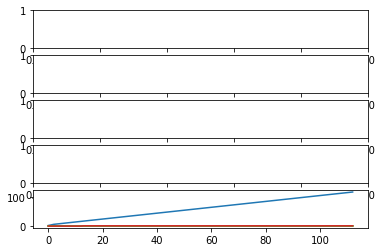

In [18]:
fm.sim_history()

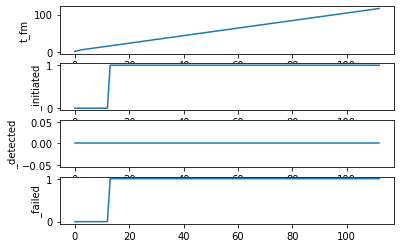

In [32]:
nrows = len(fm._history)
fig, ax = plt.subplots(nrows=4, ncols=1)

row = 0
for field in fm._history:

    ax[row].plot(fm._history[field])
    ax[row].set_ylabel(field)
    row = row + 1

In [24]:
row

4